This notebook implements a custom convolutional neural network (CNN) to classify Alzheimer's disease from anatomical MRI images. It explores hyperparameter tuning to optimize model performance and applies a distributed training strategy using TensorFlow's MirroredStrategy to accelerate training.

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import pickle, os
from IPython.display import clear_output

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from visualize import visualize_training
from data_io import save_model_s3, load_model_s3, save_pickle_s3, load_pickle_s3

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed.pkl'
data=load_pickle_s3(bucket_name, s3_file_name, dbutils)

train_data=data['train_data']
train_lab=data['train_labels']
test_data=data['test_data']
test_lab=data['test_labels']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Define custom CNN and distributed training strategy

In [0]:
def create_model():
    # three convolutional layers and one fully connected layer
    model = keras.Sequential([
        keras.Input(shape = (128, 128, 1)),

        keras.layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(
            filters=64, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(
            filters=128, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'), # fully connected layer
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

clear_output(wait=False)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,484 (24.86 MB)

 Trainable params: 6,516,484 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Fit model

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history = model.fit(
    train_data, 
    train_lab_cat, 
    epochs=25, 
    batch_size=32, 
    validation_data=validation_data, 
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

Model uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucketAD_MRI_classification/results/model_custom_CNN.h5
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_custom_CNN.pkl


Visualize model fit

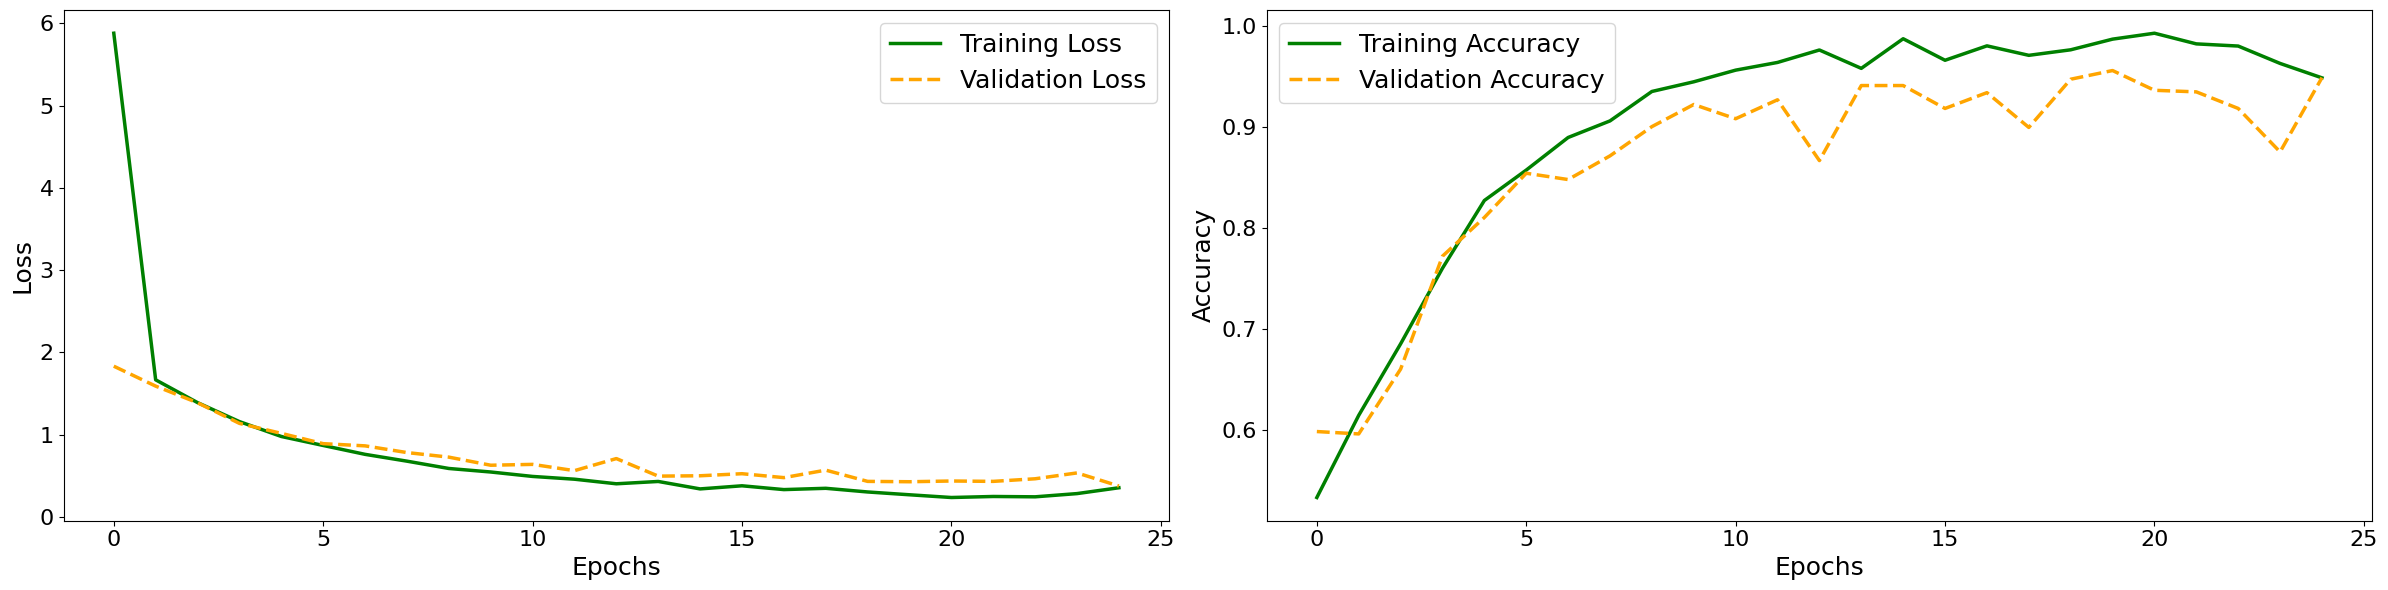

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/history_custom_CNN.pkl'
history = load_pickle_s3(bucket_name, s3_file_name, dbutils)
clear_output(wait=False)

visualize_training(history)

Predict test data, evaluate accuracy and visualize

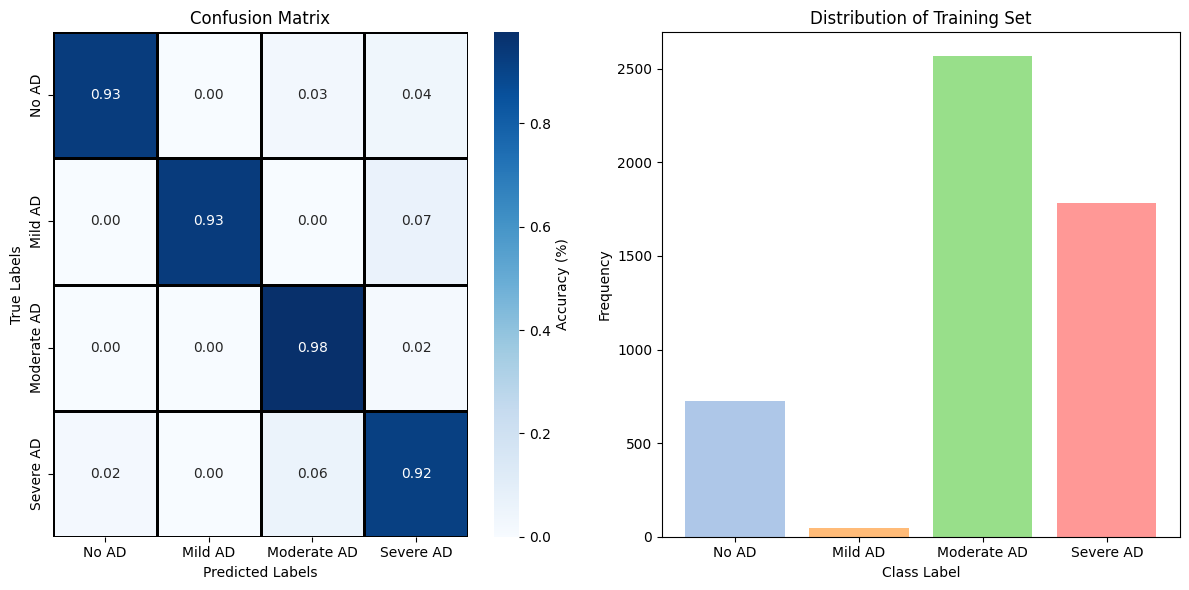

In [0]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/model_custom_CNN.h5'
model = load_model_s3(bucket_name, s3_file_name, dbutils)

# Predict test data
prob = model.predict(test_data)
predict_classes = np.argmax(prob, axis=1)
clear_output(wait=False)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_lab, predict_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Accuracy (%)'}, 
            xticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            yticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            ax=ax[0], linewidths=1, linecolor='black')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].set_title('Confusion Matrix')

# Bar plot for the distribution of the test set
train_label_counts = pd.Series(train_lab).value_counts().sort_index()
ax[1].bar(train_label_counts.index, train_label_counts.values, color=['#aec7e8', '#ffbb78', '#98df8a', '#ff9896'])
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Training Set')
ax[1].set_xticks(train_label_counts.index)
ax[1].set_xticklabels(['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'])

plt.tight_layout()
plt.show()

Overall we do not see a direct link between the test set class accuracies and the number of measurements in the training set. In fact the class with the lowest number of training measurements achieved the second highest accuracy. Therefore, even though it would be ideal to have completely (or moreso) balanced training classes, this is not a major bias in the current model.

Define hyperparameters to tune and the corresponding parameter space

In [0]:
# Same architecture as before, but with hyperparameter ranges
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 32), 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), 
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 96, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 256, step = 32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
        
    keras.layers.Dropout(0.5),
        
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

Initiate tuner

In [0]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3, directory='/Workspace/Users/bjedelma@gmail.com', project_name='AD_class')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /Workspace/Users/bjedelma@gmail.com/AD_class/tuner0.json


Run search

In [0]:
# Tune parameters on subset of data to conserve time/memory
subset = []
for label in np.unique(train_lab):
    label_indices = np.where(train_lab == label)[0]
    np.random.shuffle(label_indices)
    subset.extend(label_indices[:int(0.25 * len(label_indices))])
subset = np.array(subset)
train_data_tune = train_data[subset,:,:]
train_lab_tune = train_lab[subset]

# Plot bar graph of label distribution in subset
label_counts = np.bincount(train_lab_tune)
labels = np.arange(len(label_counts))

train_lab_tune_cat = to_categorical(train_lab_tune.astype('int8'))
test_data_tune = test_data
test_lab_tune_cat = to_categorical(test_lab.astype('int8'))

In [0]:
tuner.search(
    train_data_tune,
    train_lab_tune_cat,
    epochs = 10,
    callbacks = [stop_early],
    validation_data = (test_data_tune, test_lab_tune_cat)
)

Trial 30 Complete [00h 41m 40s]
val_accuracy: 0.589062511920929

Best val_accuracy So Far: 0.7109375
Total elapsed time: 05h 39m 48s


Even though this accuracy is lower than expected given the previous results, tuning was performed on a subset of training data and with limit training epochs to conserve time and memory. Nevertheless, training data was randomly sampled and should be representative of the total dataset. Therefore, we will use the best hyperparameters found here for further model training.

In [0]:
# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Save best hyperparameters
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/best_hps_custom_CNN.pkl'
save_pickle_s3(best_hps, bucket_name, s3_file_path, dbutils)

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/best_hps_custom_CNN.pkl


In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/best_hps_custom_CNN.pkl'
best_hps = load_pickle_s3(bucket_name, s3_file_path, dbutils)

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 3 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('dense_1_units')}

Learning Rate: {best_hps.get('learning_rate')}
""")


Optimal parameters are as follows:

Filter 1 output dim: 96
Filter 2 output dim: 64
Filter 3 output dim: 128

Dense layer units: 224

Learning Rate: 0.0001



Re-train with all data and optimal hyperparameters

In [0]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_data,
    train_lab_cat,
    epochs = 25,
    callbacks = [stop_early],
    validation_data = (test_data, test_lab_cat),
    )

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN_best_hp.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN_best_hp.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

Model uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucketAD_MRI_classification/results/model_custom_CNN_best_hp.h5
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_custom_CNN_best_hp.pkl


Best epoch: 20


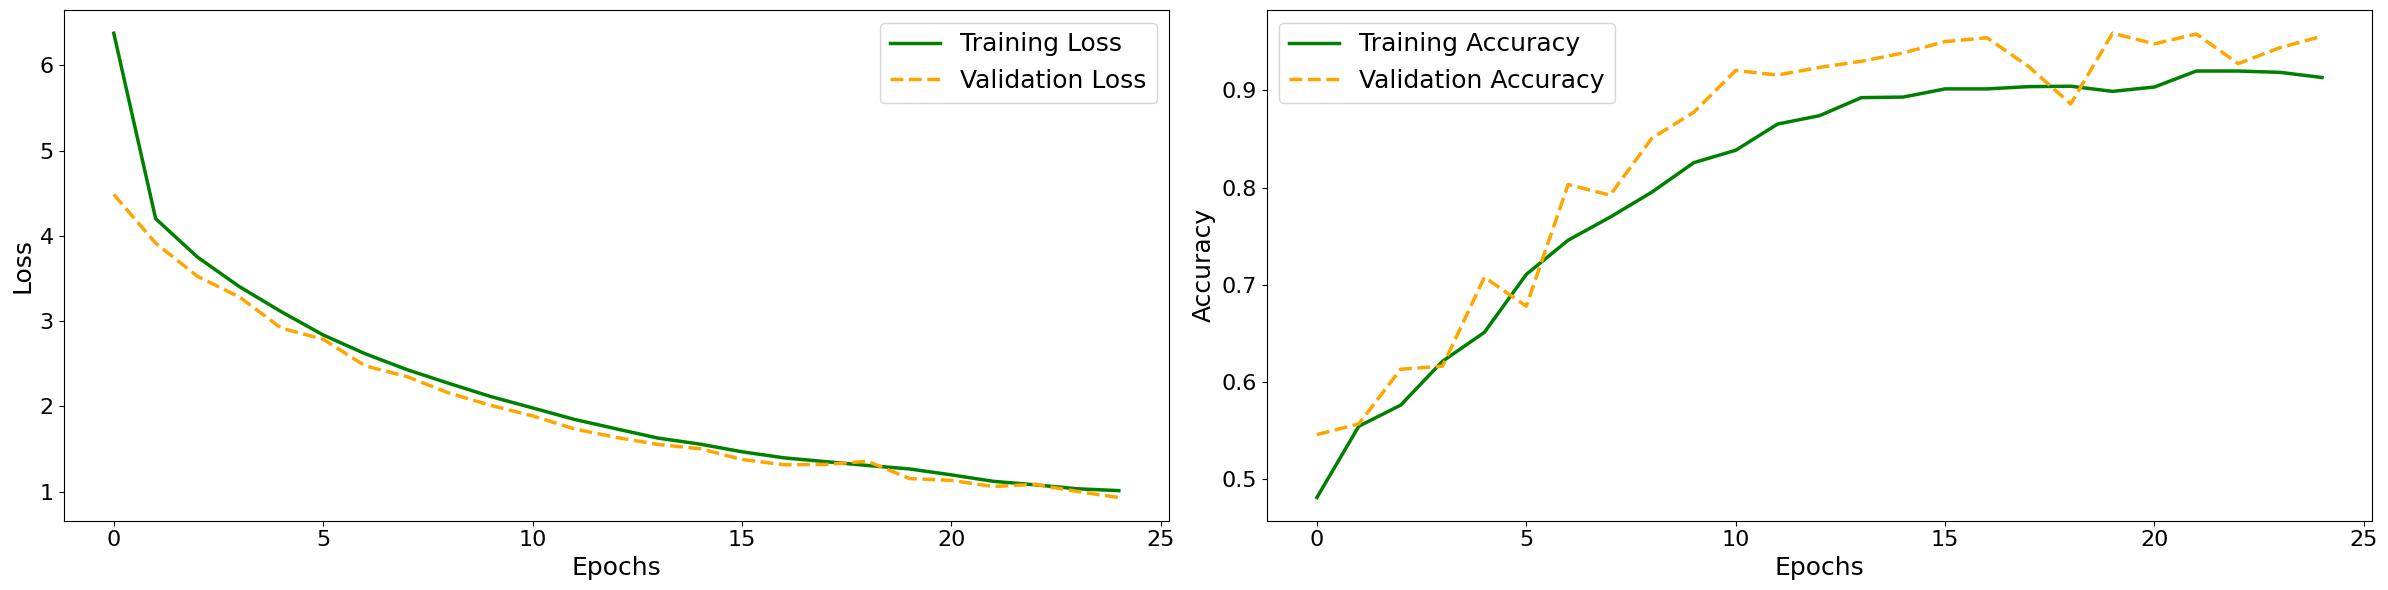

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_custom_CNN_best_hp.pkl'
history = load_pickle_s3(bucket_name, s3_file_path, dbutils)
clear_output(wait=False)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

visualize_training(history)

40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 802ms/step


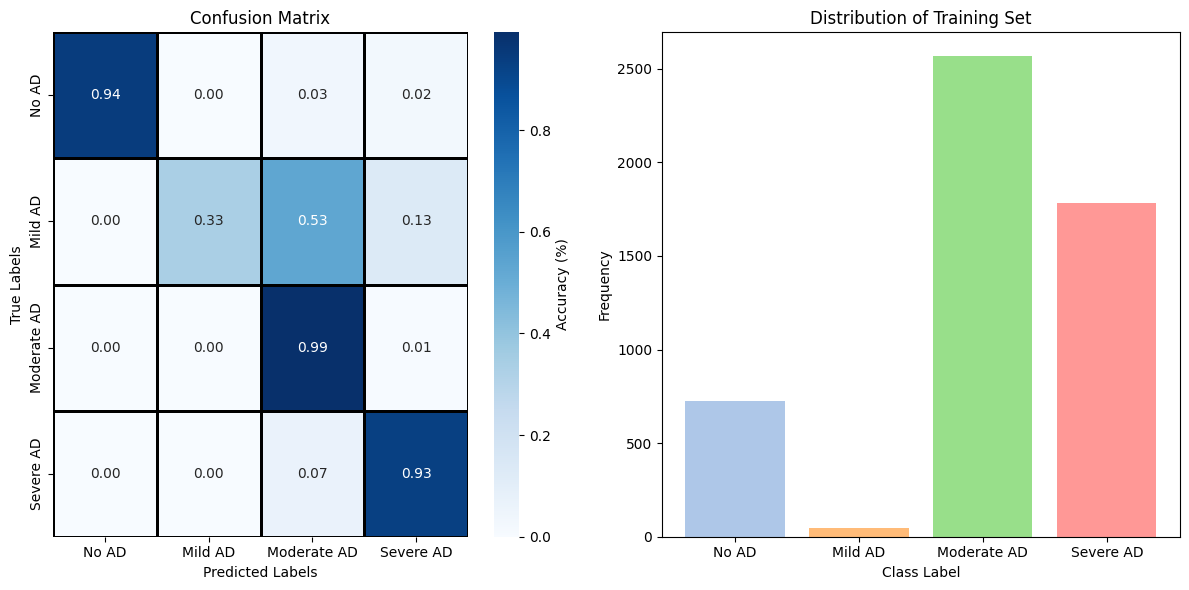

In [0]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_custom_CNN_best_hp.h5'
model=load_model_s3(bucket_name, s3_file_path, dbutils)

# Predict test data
prob = model.predict(test_data)
predict_classes = np.argmax(prob, axis=1)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_lab, predict_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Accuracy (%)'}, 
            xticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            yticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            ax=ax[0], linewidths=1, linecolor='black')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].set_title('Confusion Matrix')

# Bar plot for the distribution of the test set
train_label_counts = pd.Series(train_lab).value_counts().sort_index()
ax[1].bar(train_label_counts.index, train_label_counts.values, color=['#aec7e8', '#ffbb78', '#98df8a', '#ff9896'])
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Training Set')
ax[1].set_xticks(train_label_counts.index)
ax[1].set_xticklabels(['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'])

plt.tight_layout()
plt.show()